In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load and prepare the MNIST dataset

In [3]:

data = np.load('data_codingset_ash.npz')

#print(data['label'])
data_ash = np.array(data['data_ash'])
label = np.array(data['label'])[0]

#print(np.array(data['label'])[0])

print(data_ash.shape)

#plt.imshow(val_images[0])

(1000, 256, 256)


In [20]:
train_images, rest_images, train_label, rest_label = train_test_split(data_ash, label, test_size=0.4, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(rest_images, rest_labels, test_size=0.2, random_state=13052020)

print(test_labels)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 256, 256 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 2
train_labels = tensorflow.keras.utils.to_categorical(train_label, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

[0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 1.]


In [7]:
print(sigma_train)

36.770448188628336


In [8]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (600, 256, 256, 1)
 > labels: (600, 2)
Validation set:
 > images: (320, 256, 256, 1)
 > labels: (320, 2)
Test set:
 > images: (80, 256, 256, 1)
 > labels: (80, 2)


# Verify first 5 mages in each split dataset

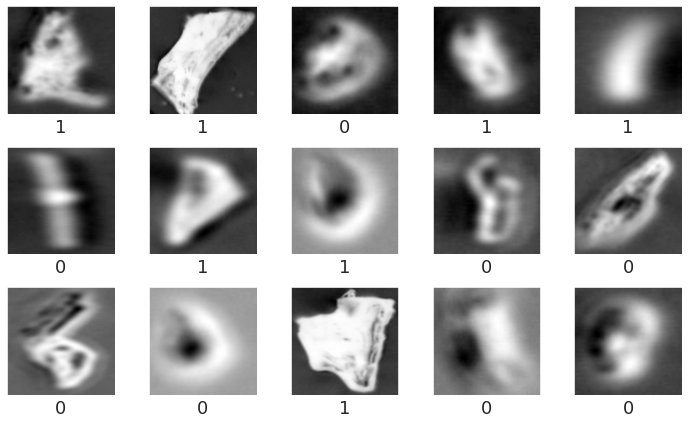

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))

N = 256

for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

# Check for (un)balanced data

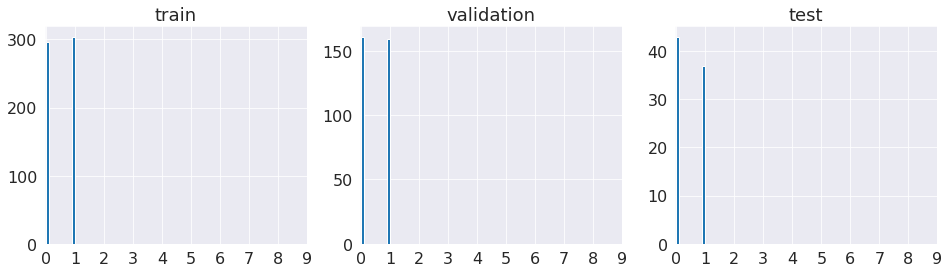

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

# Create architecture

See if you can also draw the below architecture, making it clear to others what exactly you've done/used.

In [85]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))


#model.add(Conv2D(filters=64,
#                 kernel_size=3,
#                 strides=1,
#                 padding='same',
#                 activation='relu'))
#
#model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)              

# Compile and train model

In [86]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=128,
                    epochs=5,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/5
5/5 [==============================] - 14s 3s/step - loss: 0.6767 - categorical_accuracy: 0.5307 - val_loss: 0.6340 - val_categorical_accuracy: 0.5531
Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 0.6388 - categorical_accuracy: 0.5636 - val_loss: 0.6041 - val_categorical_accuracy: 0.5938
Epoch 3/5
5/5 [==============================] - 13s 3s/step - loss: 0.6134 - categorical_accuracy: 0.6162 - val_loss: 0.5779 - val_categorical_accuracy: 0.6625
Epoch 4/5
5/5 [==============================] - 14s 3s/step - loss: 0.5874 - categorical_accuracy: 0.6648 - val_loss: 0.5584 - val_categorical_accuracy: 0.6969
Epoch 5/5
5/5 [==============================] - 15s 3s/step - loss: 0.5660 - categorical_accuracy: 0.6781 - val_loss: 0.5424 - val_categorical_accuracy: 0.7219


# Inspect learned kernels

1st convolution layer:


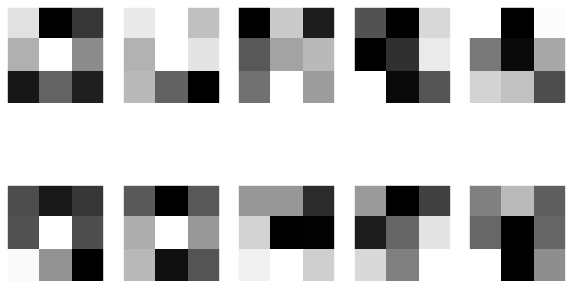

2nd convolution layer:


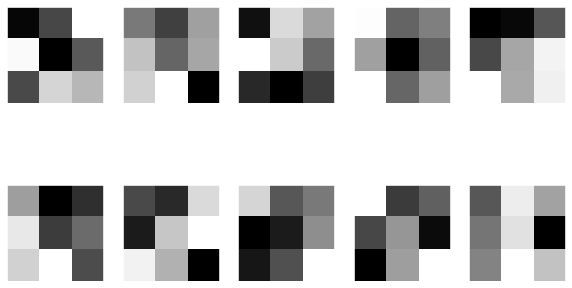

In [87]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Evaluate training process

10/10 - 2s - loss: 0.5424 - categorical_accuracy: 0.7219


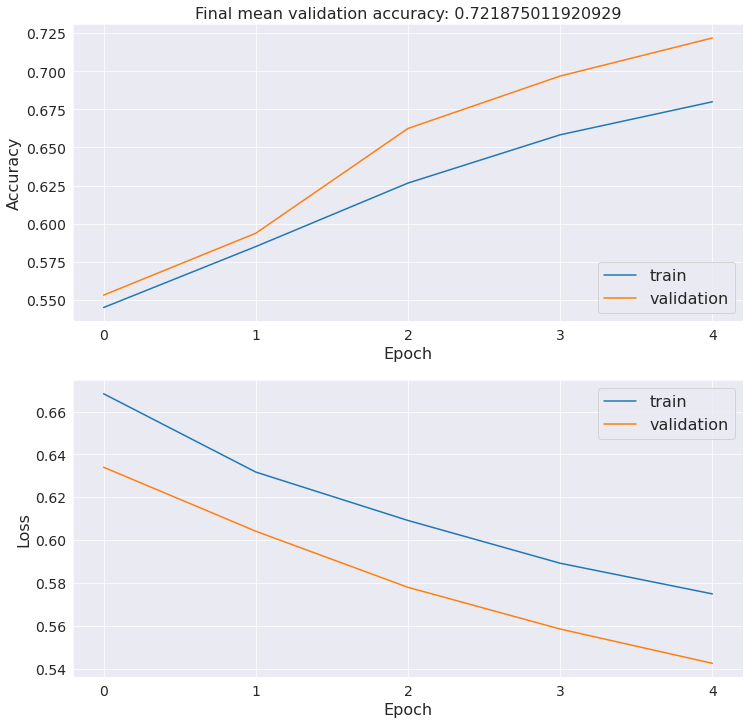

In [88]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

# Inference

In [89]:
# using until now unseen data
predicted_prob = model.predict(test_images)
predictions = np.argmax(predicted_prob, axis=1)

In [90]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[27 16]
 [ 8 29]], shape=(2, 2), dtype=int32)


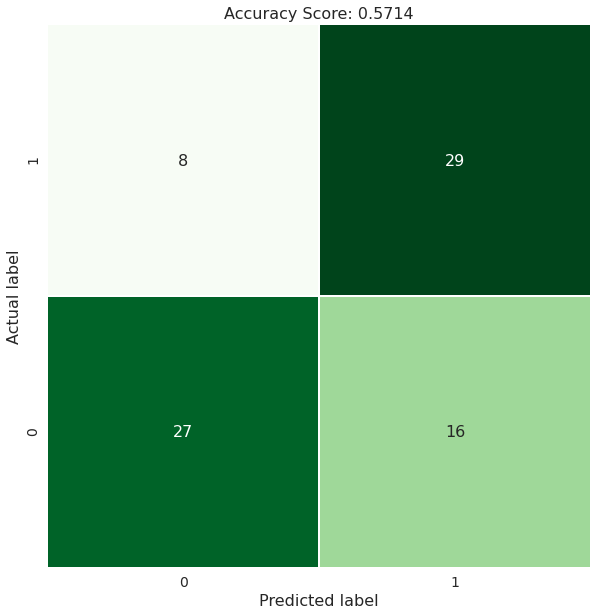

Correct: 56/80
Wrong: 24/80


In [91]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# Inspection of predictions

### Correctly predicted images

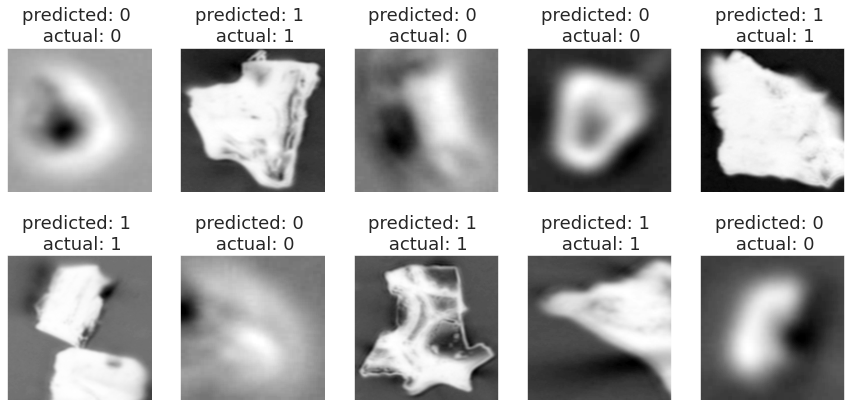

In [92]:
# show first 10 images that were correctly predicted
correct_idx = np.where(predictions == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Wrongly predicted images

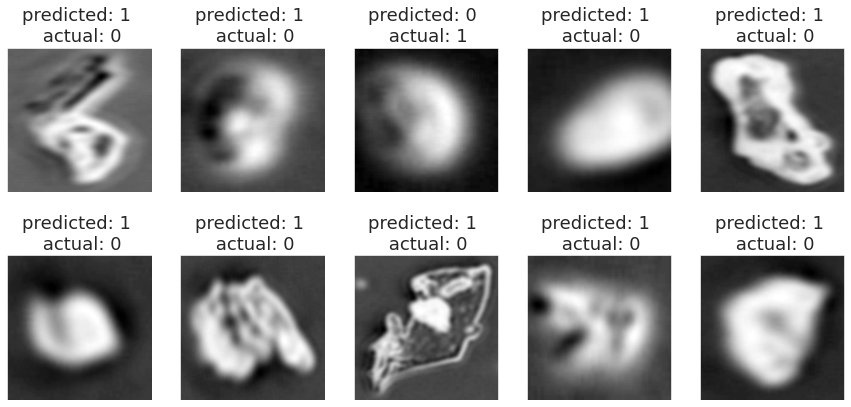

In [93]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(predictions != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Final note:

This reflects a very simple and crude CNN model. Since MNIST is a relatively straightforward dataset, using a "larger" (i.e. full scale) CNN model, you should expect even better results! However, the real test is, if you can apply the above approach to another more complicated dataset.

Also, as the size of the problem grows (larger images!!!), the use of GPUs becomes necessary. They are typically a factor 50-100 faster.